In [110]:
%matplotlib inline

from IPython.core.display import HTML
from matplotlib import pyplot as plt
from matplotlib import colors as colorscm
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy import cluster
import numpy as np
import pandas as pd
import seaborn as sns
import os
from itertools import product
#import survey_utils

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [76]:
# Variables to control details:

# Percentile cutoff in number of zeroes respondents
# are allowed to have before being discarded. Number
# controls place in sorted list of respondents' number of
# zeroes:
#
#    respondent10   4
#    respondent36   6
#    respondent2    10
#      ...
# Only respondents below <respondent_cutoff>% of the length of this
# list are included:

respondent_cutoff = 0.60
if respondent_cutoff > 1.0:
    raise ValueError('Respondent cutoff must be between 0 and 1')
    
# The 'k' in k-means clustering:
num_clusters = 5

In [77]:
# Variables holding different cuts of the responses:

# qs          all slider and likert questions. Questions are rows, respondents are columns
# good_qs     Like qs, non-serious respondents excluded
# qs_sliders  Like good_qs, but only slider responses, and output-var questions omitted
# qs_likerts  Like good_qs, but only likert responses, and output-var questions omitted

# obs         all slider and likert questions. Respondents are rows, questions are columns
#             This is the classic rows-are-observations format
# good_obs    Like obs, but with non-serious respondents excluded
# obs_sliders Like good_obs, but only slider responses, and output-var questions omitted
# obs_likerts Like good_obs, but only likert responses, and output-var questions omitted


In [78]:
html_str = """
<h1>Analysis Including Only Serious Respondents</h1>
<p>
<div class="explanation">
This analysis includes all slider and likert questions. But only
'serious' respondents are included. Seriousness was measured by
how many zeroes a respondent left. Serious respondents left at most
as many zeroes as %s%% of all respondents. 
<p>
Three alternatives are presented for combining questions:
<ul>
<li>Pairwise correlations are computed from the answers to all questions.
These correlations are sorted, highest first. The resulting list can be
considered top to bottom. The lower a question pair is on the list, the
less similar the two questions are in the insights they capture.
</li>
<li>A dendrogram approach that uses the <a href="https://en.wikipedia.org/wiki/Ward%%27s_method">
<i>Ward</i></a> algorithm for creating clusters
of 'related' questions, based on 'similarity' between the answers to those questions.
Similarity is measured by how similar the variances in the answers to the two questions are.</li>
<li>A dendrogram approach using the <a href="https://en.wikipedia.org/wiki/UPGMA"><i>UPGMA</i></a>
a.k.a. <i>averaging</i> algorithm.</li> Clusters are formed by minimizing the sum of 
distances between all pairs in one cluster and all pairs in neighboring clusters.
</ul>
The first method is the most direct and understandable.
</div>
""" % (
    100*respondent_cutoff)
HTML(html_str)

In [79]:
     from IPython.core.display import HTML, display
     HTML("""
         <style>
           h1        {text-align : center}
           .subtitle {text-align : center}
           .explanation {font-size : large; 
                         line-height : 125%;
                        }
           .container { width:100% !important; }
           .highlight { background-color : yellow;}
           hr         { height : 3px;
                        background: black
                      }
         </style>
         """)


In [286]:
def print_all(x):
    '''
    Print all of a series or data frame, not just
    an excerpt from the top and bottom.
    '''
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
def hasnans(data):
    '''
    Returns true if given series or data frame
    contain at least one NaN
    '''
    if isinstance(data, pd.DataFrame):
        return data.isnull().any().any()
    elif isinstance(data, pd.Series):
        return data.isnull().any()
    else:
        return data.isnull()
    
def is_populated(data_series, percentage_good=60):
    '''
    Returns True if at least percentage_good percent
    of the given Series has non-zero, non-NaN values.
    '''
    
    if not isinstance(data_series, pd.Series):
        raise ValueError('Must pass a pandasSeries instance; passed type was %s' % type(data_series))
    
    # Add up nulls and zeroes:
    try:
        nan_count = data_series.isnull().value_counts()[True]
    except KeyError:
        nan_count = 0
        
    try:
        zero_count = data_series.value_counts().loc[0]
    except KeyError:
        zero_count = 0
        
    bad_count = nan_count + zero_count
    
    percent_bad = bad_count * 100/len(data_series)
    return percent_bad <= percentage_good



In [82]:
# Get the slider and likert responses:
data_path = os.path.join(os.getenv("HOME"), 
                        #'Project/WomenIndustrySurveyHolzblatt/Data/DataForClustering/slidersLikertByItem.csv'
                        'Project/WomenIndustrySurveyHolzblatt/Data/DataForClustering/likertSlidersByRespondentUnfolded.csv'
                       )

data = pd.read_csv(data_path, sep=',')
# Make the question column the index, so that
# all operations on the dataframe only address
# the numeric scores:
qs = data.set_index('question')
# Replace 0s with their column's median.
#data = utils.replaceZerosDataFrame(data, direction='row')


In [83]:
# Get metadata for each question: Was it likert or slider?
# Was it an output variable or not?
q_metatdata_path = os.path.join(os.getenv("HOME"), 
                        'Project/WomenIndustrySurveyHolzblatt/Data/DataForClustering/questionMetadata.xlsx'
                       )
qmeta = pd.read_excel(q_metatdata_path)
#          Question        QuestionType  IsOutputVar
# 0    Team|GetsInWay         slider       0
# 1    Team|LooseGroup        likert       0
# 2    Team|Alienated         slider       0

# Make question into the index:
qmeta = qmeta.set_index('Question')
qmeta.head(3)

QuestionType  IsOutputVar
Question                                 
Team|GetsInWay        slider            0
Team|LooseGroup       slider            0
Team|Alienated        slider            0

In [84]:
# Drop all questions (rows) that nobody answered:
qs = qs.loc[~(qs==0).all(axis=1)]

In [85]:
# Drop all participants who answered no questions:
qs = qs[qs.columns[(qs != 0).any()]]

In [86]:
print(' %s percent of the respondents.' % (100*respondent_cutoff))
#print(' %s percent of the respondents.' % 60)

 60.0 percent of the respondents.


In [87]:
html_str  = '<div class="explanation">'
html_str += "Find respondents who answered 'most' questions. Method: "
html_str += 'Count the number of zeroes in the answers of every respondent. Sort '
html_str += 'the respondents in increasing order of those zero-responses. '
html_str += 'Accept the first '
html_str += ' %s percent of the respondents.' % (100*respondent_cutoff)
html_str += '</div>'

HTML(html_str)


<div class="explanation">Find respondents who answered 'most' questions. Method:
Count the number of zeroes of every respondent. Sort
those numbers in increasing order. Accept the first
75% of the respondents (can change that cutoff above).
</div>

In [88]:
# Get number of zeroes for each respondent,
# sorted ascending :
#   s14 12
#   s3  14
#   s18 15
respondent_zeroes = qs[qs == 0].count().sort_values(ascending=True)
#num_zeroes.head(20)
# Get array of respondent IDs to include: take the
# first <respondent_cutoff> percent of the sorted
# list:
index_to_cutoff = int(np.floor(respondent_cutoff*len(respondent_zeroes)))
# ... and keep only the lower part:
respondents_to_use = respondent_zeroes[:index_to_cutoff].index


In [89]:
html_str = '<div class="explanation">'

html_str  = 'Number of likert/slider questions: <span class="highlight">%s</span><br>' % len(qs)
html_str += 'Median number of unanswered questions all respondents: %s<br>' % respondent_zeroes.median()
html_str += 'Mean number of unanswered questions all respondents: %s<br>' % respondent_zeroes.mean()
html_str += 'Max number of unanswered questions all respondents: %s<br>' % respondent_zeroes[-1]
html_str += '<br>'
html_str += 'Number of all respondents: %s<br>' % len(respondent_zeroes)

html_str += '<br>'

html_str += 'For %sth percentile respondents:' % int(respondent_cutoff*100)
html_str += 'Median number of unanswered questions for selected respondents: %s<br>' % respondent_zeroes[:index_to_cutoff].median()
html_str += 'Mean number of unanswered questions: %s<br>' % respondent_zeroes[:index_to_cutoff].mean()
html_str += 'Max number of unanswered questions: %s<br>' % respondent_zeroes[index_to_cutoff]
html_str += 'Number of accepted respondents: <span class="highlight">%s</span><br>' % len(respondents_to_use)

html_str += '</div>'

HTML(html_str)


In [90]:
# Get new variables for the rows-are-questions
# and rows-are-respondents that include only 
# the respondents we want to use:
good_qs  = qs[respondents_to_use]

# Turn nums into floats for later use:
good_qs = good_qs.astype(np.float)
good_obs = good_qs.transpose()


In [167]:
# Need one more table: data limited to slider responses

# Get question-in-rows data with two
# additional columns: QuestionType and IsOutputVar.
# Both are from the qmeta table:
#                               s100   s98    s97    QuestionType  IsOutputVar
# Balance|CantBeLeader            87.0   87.0   87.0    likert           0
# Balance|CompanyFlexible         62.0   62.0   62.0    likert           0
# Balance|CultureSupportive       87.0   87.0   87.0    likert           0
#
# We'll use that to pull out only the slider questions
# that are not also output variables:

good_qs_meta = good_qs.join(qmeta)
#good_qs_meta.head(3)
# Do the row selection, then drop the 'QuestionType' and 'IsOutputVar' cols:

qs_sliders  = good_qs_meta.loc[(good_qs_meta['QuestionType'] == 'slider') & (good_qs_meta['IsOutputVar'] == 0)]
qs_sliders  = qs_sliders.drop('QuestionType', axis=1).drop('IsOutputVar', axis=1)
obs_sliders = qs_sliders.transpose()

qs_likerts  = good_qs_meta.loc[(good_qs_meta['QuestionType'] == 'likert') & (good_qs_meta['IsOutputVar'] == 0)]
qs_likerts  = qs_likerts.drop('QuestionType', axis=1).drop('IsOutputVar', axis=1)
obs_likerts = qs_likerts.transpose()


Balance|CantBeLeader  Balance|CompanyFlexible  \
s100                  87.0                     62.0   
s98                   87.0                     62.0   
s97                   87.0                     62.0   

      Balance|CultureSupportive  Balance|FeelJudged  Balance|HateCulture  \
s100                       87.0                87.0                 87.0   
s98                        87.0                62.0                 62.0   
s97                        87.0                62.0                 62.0   

      Balance|ManagerSendsHome  Balance|OkToGoHome  Balance|OkToTalk  \
s100                      87.0                87.0              87.0   
s98                       87.0                87.0              87.0   
s97                       87.0                87.0              87.0   

      Balance|OkWithChildren  Balance|PartTimeButCareer         ...          \
s100                    87.0                       37.0         ...           
s98                     87.0                       12.0         ...           
s97                     87.0                        0.0         ...           

      Promoted|IfAskThenPushy  Promoted|MetCriteria  Promoted|MustNetwork  \
s100                     62.0                  87.0                  87.0   
s98                      62.0                  87.0                  87.0   
s97                      62.0                  87.0                  87.0   

      Promoted|MustSelfPromote  Promoted|TooMuchWork  Promoted|UnsureWhatToDo  \
s100                      62.0                  62.0                     62.0   
s98                       62.0                  62.0                     62.0   
s97                       62.0                  62.0                     62.0   

      With|HateCulture  With|ManagerImportant  With|ManagerMicromanages  \
s100              87.0                   87.0                      87.0   
s98               87.0                   87.0                      87.0   
s97               87.0                   87.0                      62.0   

      With|NewJobAnyCase  
s100                87.0  
s98                 87.0  
s97                 87.0  

[3 rows x 74 columns]

<h2>Correlation Matrix Method for Finding Similar Questions</h2>
<div class="explanation">
We examine correlations separately for sliders and likerts, because
sliders are truly continuous, while likerts are 'stretched' to be
between 0 and 100, but still only fall on very few fixed values 
in that range: [  0.,  12.,  37.,  62.,  87.]
</div>

In [264]:
def create_corr_info(data, minimum_compliance=None, null_values=[]):
    '''
    Given a data frame, compute pairwise correlations
    between the columns. Return a tuple (matrix, df).
    Matrix:
             col1    col2     col3
     col1     1      -.3       1
     col2    .4       1        0.2
     col3    .6       .5       1
     
    Df:
    
          Questions      Correlations
          (col1,col2)        -.3
          (col2,col1)         .4
                 ...

    :param data: the data frame to work on
    :type df({int|float}, {int|float})
    :param minimum_compliance: a percentage. Only columns whose
        values are at least minimum_compliance percent 'acceptable'
        are considered. For which values are considered acceptable,
        see parameter null_values.
    :type minimum_compliance: {int|float}
    :param null_values: list of values that are to be considered null.
        For example, in surveys the value zero might mean a question
        not having been answered. Any values in the given list (or the
        np.nan value) are not considered in the correlations.
    :type null_values: list({int|float})
    '''
    
    # Make a copy of the data in which any occurrence of
    # null_values is replaced with np.nan. We
    # use the Pandas df.replace() method, passing a dict of
    # {val1_ToReplace : np.nan, val2_toReplace : np.nan}.
    # We build the dict using Pythons dict(array_of_key_val_tuples):
    
    repl_dict = dict([(k, np.nan) for k in null_values])
    valid_data = data.replace(to_replace=repl_dict)    
    
    if minimum_compliance is not None:
        try:
            minimum_compliance = float(minimum_compliance)
        except ValueError:
            raise ValueError("Argument 'minimum_compliance' must be int or float; was '%s'" % minimum_compliance)
        # Remove columns with all np.nan (e.g. questions nobody answered):
        valid_data = valid_data[valid_data.columns[(valid_data != np.nan).any()]]
        
        # Remove columns that have fewer then minimum_compliance% good entries.
        # The first statement passes one column at a time to 
        # is_populated(), demanding at least the given compliance level
        # This generates:
        #      col1  True
        #      col2  False
        #      col3  True
        #       ...
        # The second statement uses this boolean series to
        # select columns:
        
        cols_populated = data.apply(is_populated, percentage_good=minimum_compliance)
        valid_data = valid_data[cols_populated.index[cols_populated]]
        
    # The Pandas function corr() does correlations between
    # all column pairs, ignoring NaN fields. 
    corr_matrix = valued_data.corr()
    
    # Get rid of the upper-right triangle of the correlation matrix:

    #array([[ True, False, False],
    #       [ True,  True, False],
    #       [ True,  True,  True]], dtype=bool)

    corr_matrix_tri_lower_mask = np.tril(np.ones(corr_matrix.shape).astype(np.bool))

    # Use this mask to turn upper triangle into NaNs:
    corr_matrix_tri_lower = corr_matrix.where(corr_matrix_tri_lower_mask) 
    
    row_name_series = pd.Series(corr_matrix_tri_lower.index.values)
    col_name_series = pd.Series(corr_matrix_tri_lower.columns.values)
    # Get: Series([(SurveyItem1, SurveyItem1),
    #              (SurveyItem1, SurveyItem2),
    #              (SurveyItem1, SurveyItem3),
    #              (SurveyItem2, SurveyItem1),
    #              (SurveyItem2, SurveyItem2),
    #              (SurveyItem2, SurveyItem3),
    #                     ...
    #            ])
    all_cell_names  = pd.Series(list(product(row_name_series, col_name_series)))

    # Flatten the correlation matrix into a 1-column DF:
    corrs_df = pd.DataFrame(corr_matrix_tri_lower.values.flatten(), index=all_cell_names, columns=['Correlations'])

    # Remove the diagonal 1s entries: 

    # Currently the question-pairs are the index. Turn them into a 
    # second column named 'Questions':
    #                   	Questions                       	Correlations
    #    0 	(PersonalExperience|ILackConfidence, PersonalE... 	1.000000
    #    1 	(PersonalExperience|ILackConfidence, WorkLife|... 	0.620947

    corrs_df = corrs_df.reset_index().rename(columns={'index' : 'Questions'})
    corrs_df = corrs_df.where(corrs_df.Questions.apply(lambda x: x[0] != x[1])).dropna()

    # Sort by descending correlation:
    # 	Questions 	Correlations
    #9404 	(Team|NotPartOfGrp, Manager|HesitateToTakeChal... 	1.000000
    #9755 	(Manager|HesitateToTakeChallenges, Team|NotPar... 	1.000000
    #     ...
    #2840 	(Promoted|UnsureWhatToDo, Promoted|DontWantClimb) 	0.995508
    #968 	(Promoted|DontWantClimb, Promoted|UnsureWhatToDo) 	0.995508
    #5330 	(Balance|ManagerSendsHome, Balance|CultureSupp... 	0.994896
    #2405 	(Balance|CultureSupportive, Balance|ManagerSen... 	0.994896
    #     ...

    corrs_df.sort_values(by='Correlations', ascending=False, inplace=True)

    return (corr_matrix, corrs_df)
    

In [325]:
(sliders_corr_matrix, sliders_pair_corrs) = create_corr_info(obs_sliders, minimum_compliance=75)
(likerts_corr_matrix, likerts_pair_corrs) = create_corr_info(obs_likerts, minimum_compliance=75)

html_str = '<span class="highlight">Number of pairwise slider correlations: %s</span><br>' % len(sliders_pair_corrs)
html_str += '<span class="highlight">Number of pairwise likert correlations: %s</span>' % len(likerts_pair_corrs)
HTML(html_str)
#print(obs_sliders.shape)
#sliders_corr_matrix.shape

In [326]:
#obs_sliders[obs_sliders.columns[(obs_sliders != 0).any()]]
#obs_sliders.loc['s127']

<h3>List of pairwise correlations in descending order; no questions with worse than 75% fill-in.</h3>
<div class="explanation">First slider questions only:</div>

In [327]:
# Print list of sorted correlations:
cm = sns.light_palette("green", as_cmap=True)
#cm = colorscm.Colormap('Greens')


styled_corrs_df = sliders_pair_corrs.style.background_gradient(cmap=cm)
styled_corrs_df

<div class="explanation">List of pairwise correlations in descending order. Now the Likerts only:</div>

In [170]:
# Print list of sorted correlations:
cm = sns.light_palette("green", as_cmap=True)
#cm = colorscm.Colormap('Greens')


styled_corrs_df = likerts_pair_corrs.style.background_gradient(cmap=cm)
styled_corrs_df

<hr>

<h2>Dendrogram Method Using Ward for Clustering</h2>
<div class="explanation">This method finds cluster members by grouping those questions that had very similar variances.
</div>

(Note: more readable question layout further down)


In [96]:
# Find the best algorithm for dendrogram clustering. Supposedly
# the algorithm with the largest Cophenet correlation coefficient
# tends to be best:

# Cophenet correlation coefficient measures 
# how faithfully a dendrogram preserves pairwise
# distance between the original data points, use
# the algo that yields the highest coefficient:

max_c = 0
max_algo = ''
max_cluster_info = None
algo_results = {}
for algo in ['ward', 'centroid', 'weighted', 'average', 'complete', 'single']:
    cluster_info = linkage(good_qs, algo)
    (c, coph_dists) = cophenet(cluster_info, pdist(good_qs))
    if c > max_c:
        max_c = c
        max_algo = algo
        max_cluster_info = cluster_info
    algo_results[algo] = {'cophenet_coeff' : c,
                          'cluster_info' : cluster_info
                          }
print("Winning Cophenet correlation coefficient is the '%s' algorithm: %s" % (max_algo, max_c))
# cluster_info = max_cluster_info
# algo = max_algo
print("... but using Ward (c= %s)" % algo_results['ward']['cophenet_coeff'])

algo = 'ward'
cluster_info = algo_results[algo]['cluster_info']


Winning Cophenet correlation coefficient is the 'average' algorithm: 0.859306745072
... but using Ward (c= 0.632157505877)


In [97]:
#good_obs.head(4)
#len(cluster_info) # 115
#cluster_info[0]   # array([ 37.,  79.,  17.,   2.])

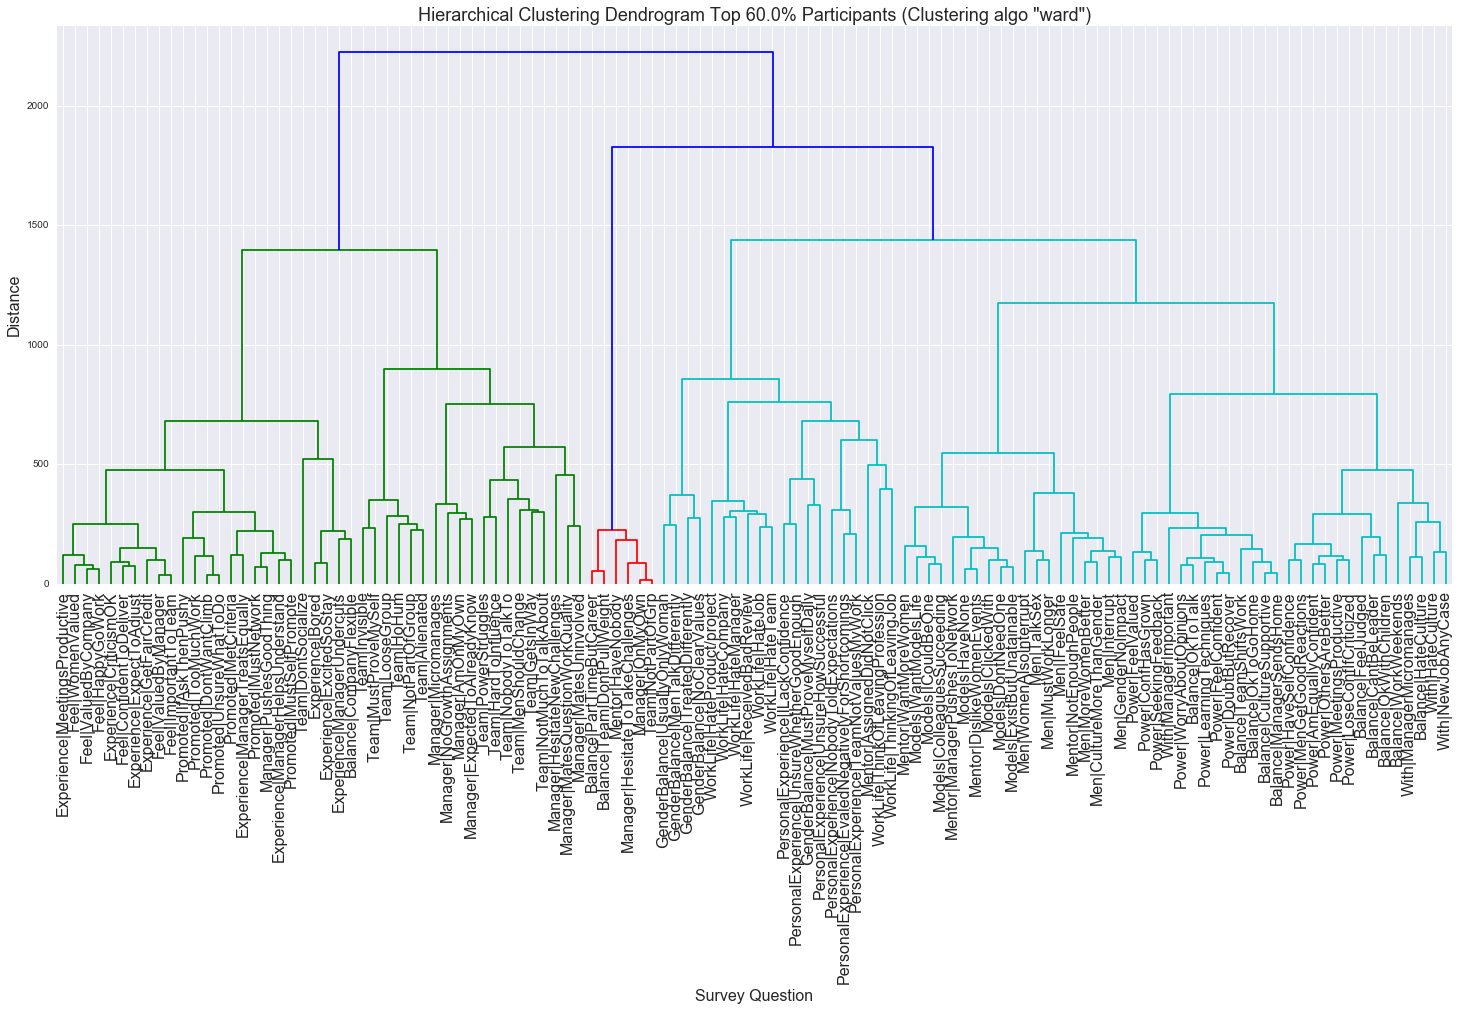

In [98]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
title = 'Hierarchical Clustering Dendrogram Top %s%% Participants (Clustering algo "%s")' % (100*respondent_cutoff, algo)
plt.title(title, fontsize=18)
plt.xlabel('Survey Question', fontsize=16)
plt.ylabel('Distance', fontsize=16)
dendrogram_data = dendrogram(
        algo_results[algo]['cluster_info'],
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        labels=good_qs.index
)
plt.show()



<div class="explanation">Make groups more readable:</div>

In [99]:
# Build a DataFrame that combines question, distance, and color.
# Then change the names of the one-letter colors to more readable
# expanded form:
clusters = zip(dendrogram_data['ivl'], dendrogram_data['leaves'], dendrogram_data['color_list'])
clusters = pd.DataFrame(clusters, columns=['Question', 'Distance', 'Color'])
clusters['Color'].replace(['g','r','b','c','m','y','k'], 
                          ['green','red','blue','cyan','magenta','yellow','black'],
                          inplace=True
                          )

# Save the Ward-based clusters for later:
ward_clusters = clusters.copy()
# Turn the 'Question' column into the index:
ward_clusters = ward_clusters.set_index('Question')

def cluster_table_styler(val):
    if val == 'green':
        return("background-color : green")
    elif val == 'red':
        return("background-color : red")
    elif val == 'blue':
        return("background-color : blue")
    elif val == 'cyan':
        return("background-color : cyan")
    elif val == 'magenta':
        return("background-color : magenta")
    elif val == 'yellow':
        return("background-color : yellow")
    elif val == 'black':
        return("background-color : black")
    else:
        return ''
    
clusters.style.applymap(cluster_table_styler)



<hr>

<h2>Alternative Dendrogram: using highest-cophenet-coefficient algorithm ('average'):</h2>
<div class="explanation">
The <i>average</i> clustering method minimizes the average distance between any two elements of neighboring clusters.
The method is also known as UPGMA <b>U</b>nweighted <b>P</b>air <b>G</b>roup <b>M</b>ethod with <b>A</b>rithmetic <b>M</b>ean.
</div>

In [100]:
def print_and_color(k):
    print(k)
    return 'Coral'

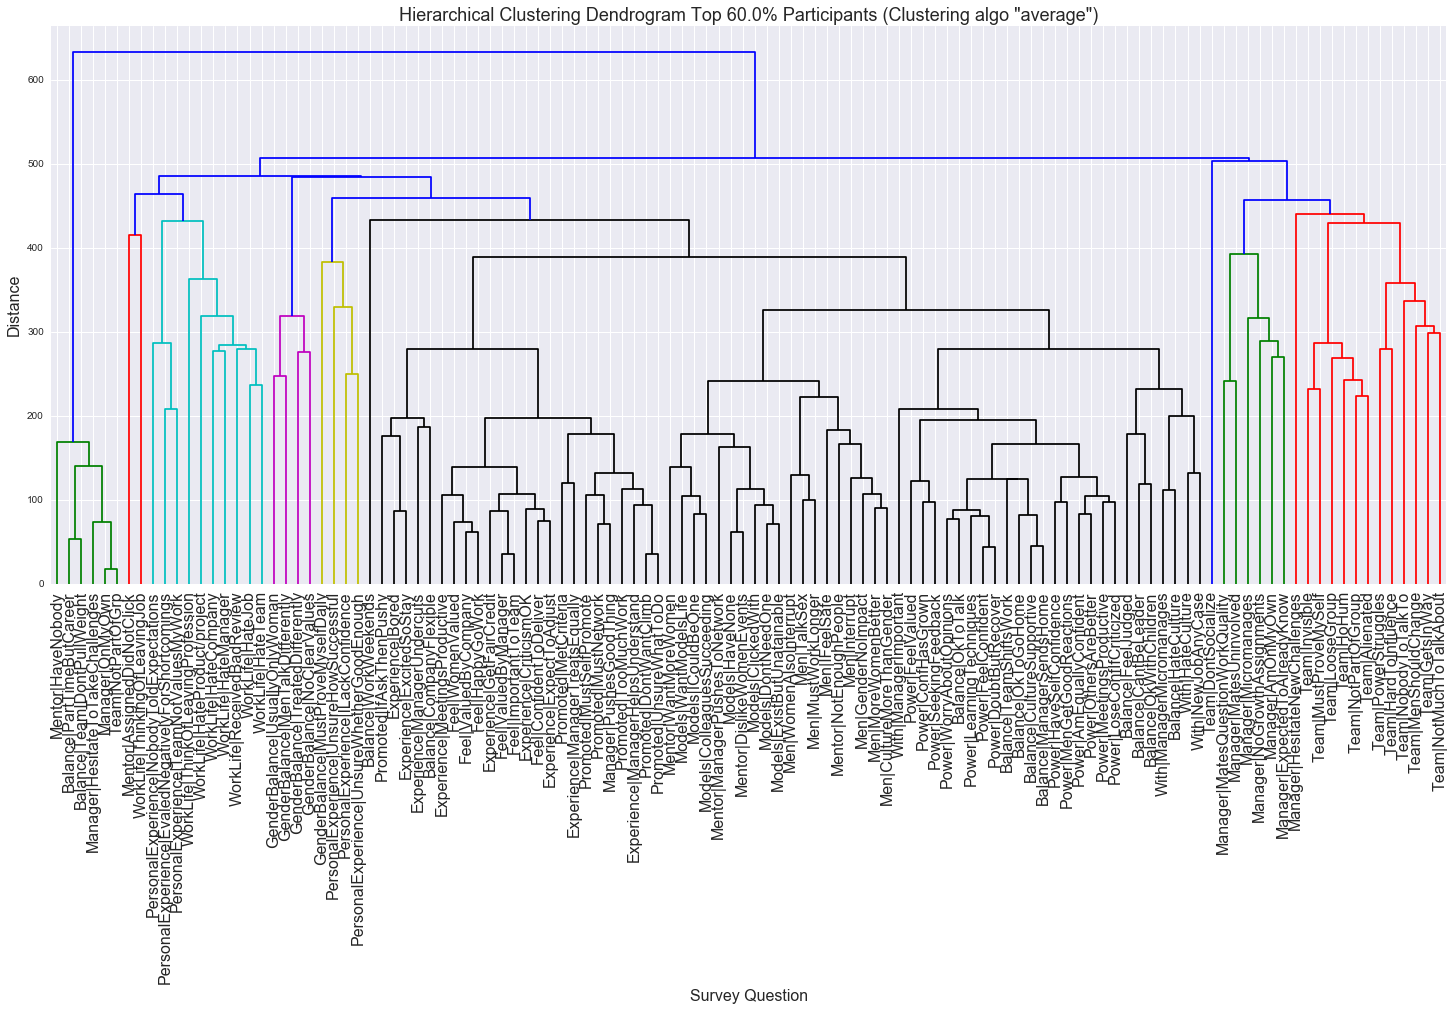

In [101]:
algo = max_algo

# calculate full dendrogram
plt.figure(figsize=(25, 10))
title = 'Hierarchical Clustering Dendrogram Top %s%% Participants (Clustering algo "%s")' % (100*respondent_cutoff, algo)
plt.title(title, fontsize=18)
plt.xlabel('Survey Question', fontsize=16)
plt.ylabel('Distance', fontsize=16)
dendrogram_data = dendrogram(
        algo_results[algo]['cluster_info'],
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        labels=good_qs.index,  # question names
)
plt.show()



<div class="explanation">
Make groups easier to read:
</div>

In [102]:
# Build a DataFrame that combines question, distance, and color.
# Then change the names of the one-letter colors to more readable
# expanded form:
clusters = zip(dendrogram_data['ivl'], dendrogram_data['leaves'], dendrogram_data['color_list'])
clusters = pd.DataFrame(clusters, columns=['Question', 'Distance', 'Color'])
clusters['Color'].replace(['g','r','b','c','m','y','k'], 
                          ['green','red','blue','cyan','magenta','yellow','black'],
                          inplace=True
                          )

def cluster_table_styler(val):
    if val == 'green':
        return("background-color : green")
    elif val == 'red':
        return("background-color : red")
    elif val == 'blue':
        return("background-color : blue")
    elif val == 'cyan':
        return("background-color : cyan")
    elif val == 'magenta':
        return("background-color : magenta")
    elif val == 'yellow':
        return("background-color : yellow")
    elif val == 'black':
        return("background-color : black")
    else:
        return ''

# Save 'average'-generated clusters for later:
average_clusters = clusters.copy()
# Turn the 'Question' column into the index:
average_clusters = average_clusters.set_index('Question')

clusters.style.applymap(cluster_table_styler)

<hr>

<h2>Cluster using K-Means, and plot some questions from the above groupings.</h2>
<div class="explanation">
Use only the slider responses, because they are truly continuous. 
Also, at this point: leave out the questions we will use as output variables
to be predicted further down.
</div>

Compute clusters for k=1 to k=10. Plot the resulting 
overall distortion for each k. Then pick a k where
the curve has an 'elbow'. Our case, 4 clusters is an option:

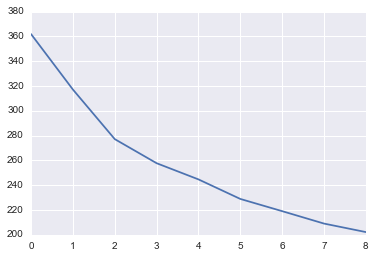

In [104]:
# Get clustering for k=1 to k=10 to see where distortion levels out:
initial = [cluster.vq.kmeans(qs_sliders, k) for k in range(1,10)]
#initial
plt.plot([distortion for (centroids, distortion) in initial])

<div class="explanation">
In the following: modify statements <br>
<code>questions_cluster_1 = green_ward_questions</code> and<br>
<code>questions_cluster_2 = cyan_ward_questions</code>
<p>
to sample questions from different clusters of the Ward dendrogram.
Options are <i>green, red, cyan, blue, and magenta</i>.
</div>


In [123]:
#70*len(questions_cluster_1)/100
len(qs_sliders.columns)
int(70*len(qs_sliders.columns)/100)
len(good_cluster1_responses)
good_qs.loc['Balance|ManagerSendsHome']

qs_sliders.loc['']

s100    87.0
s98     87.0
s97     87.0
s79     62.0
s48     62.0
s85     87.0
s57     62.0
s58     62.0
s60     62.0
s63     62.0
s65     62.0
s51     62.0
s90     87.0
s89     87.0
s68     62.0
s86     87.0
s69     62.0
s54     62.0
s71     62.0
s78     62.0
s95     87.0
s75     62.0
s77     62.0
s59     62.0
s91     87.0
s76     62.0
s37     62.0
s94     87.0
s49     62.0
s81     87.0
        ... 
s36     62.0
s42     62.0
s103    87.0
s104    87.0
s8       0.0
s109     0.0
s107     0.0
s111     0.0
s108     0.0
s110     0.0
s105     0.0
s106     0.0
s112     0.0
s113     0.0
s115     0.0
s114     0.0
s116     0.0
s117     0.0
s127     0.0
s119     0.0
s120     0.0
s126     0.0
s125     0.0
s123     0.0
s118     0.0
s124     0.0
s122     0.0
s121     0.0
s131     0.0
s133     0.0
Name: Balance|ManagerSendsHome, dtype: float64

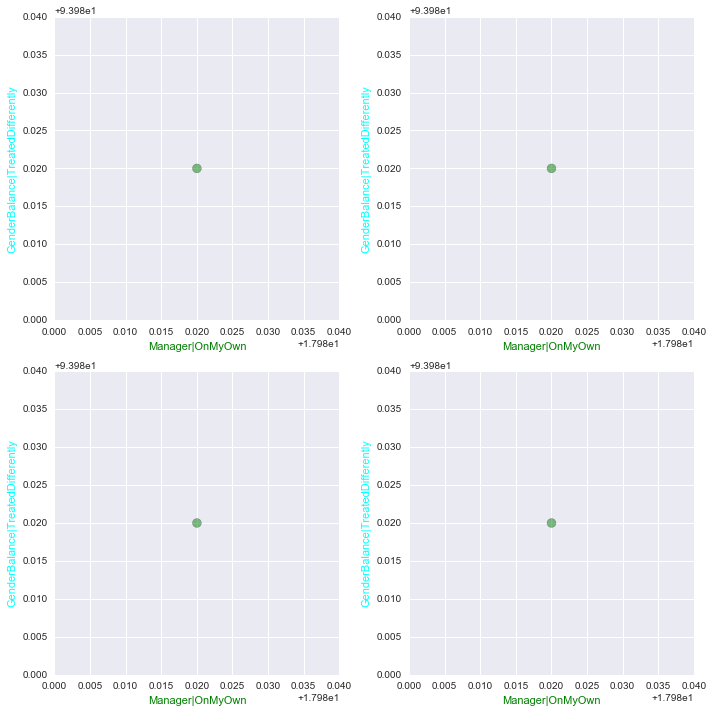

In [224]:
# Number of clusters is in num_clusters, set at the top.

cluster1_color = 'green'
cluster2_color = 'cyan'

(centroids, distortion) = initial[num_clusters - 1]

# Get as many colors as we have clusters:

number_of_colors = num_clusters
cm_subsection = np.linspace(0, 1, number_of_colors) 
accent_cmap = plt.cm.get_cmap('Accent')
colors = [ accent_cmap(x) for x in cm_subsection ]


# Assign each observation to one cluster:
(centroid_assignments, distortions) = cluster.vq.vq(qs_sliders, centroids)

# Get arrays of questions from the Ward clusters.
# But we only want the slider questions among those
# We'll then plot pairs of response vectors to random question pairs
# below:
ward_cluster_qs = {
    'green': ward_clusters[ward_clusters.Color == 'green'].index.intersection(qs_sliders.index),
    'red'  : ward_clusters[ward_clusters.Color == 'red'].index.intersection(qs_sliders.index),
    'cyan' : ward_clusters[ward_clusters.Color == 'cyan'].index.intersection(qs_sliders.index),
    'blue' : ward_clusters[ward_clusters.Color == 'blue'].index.intersection(qs_sliders.index),
    'magenta' : ward_clusters[ward_clusters.Color == 'magenta'].index.intersection(qs_sliders.index)
}

# Number of plots with different questions on x/y axes:
num_plots = 4
plot_cols = 2
plot_rows = int(np.ceil(num_plots / plot_cols))

# The axes_arr will have same shape as
# arrangement of plots: E.g. 3x2:
(fig, axes_arr) = plt.subplots(plot_rows,plot_cols)
axes = axes_arr.flatten()
fig.set_size_inches(10,10)

# Pick two clusters from which questions will be drawn:
questions_cluster_1 = ward_cluster_qs[cluster1_color]
questions_cluster_2 = ward_cluster_qs[cluster2_color]

for i in range(num_plots):
    
    # For each plot, find a pair of questions that
    # at least 70% of the respondents answered. Try
    # 40 pairs. If none found then, leave plot blank:
    for find_qpair_attempt in range(40):
        cluster1_question = np.random.choice(questions_cluster_1)
        cluster2_question   = np.random.choice(questions_cluster_2)


        # Get responses to the two sample questions by all respondents:
        cluster1_responses      = qs_sliders.loc[cluster1_question]
        cluster2_responses      = qs_sliders.loc[cluster2_question]
        
        
        #**************
        # Correlated:
        cluster1_question = 'WorkLife|ReceivedBadReview'
        cluster2_question = 'WorkLife|HateManager'
        # Not Correlated:
        cluster1_question = 'Manager|OnMyOwn'
        cluster2_question = 'GenderBalance|TreatedDifferently'        
        
        cluster1_responses = qs_sliders.loc[cluster1_question]
        cluster2_responses = qs_sliders.loc[cluster2_question]
        #print('Q1: %s' % cluster1_responses)
        #print('Q2: %s' % cluster2_responses)
        #**************        

        # Discard all respondents that did not answer *either*
        # question:    
        cluster1_non_responders = cluster1_responses.loc[cluster1_responses == 0]
        cluster2_non_responders = cluster2_responses.loc[cluster2_responses == 0]

        non_responders_either_q = cluster1_non_responders.index.union(cluster2_non_responders.index)

        # The remaining responses:
        good_cluster1_responses = cluster1_responses.drop(non_responders_either_q)
        good_cluster2_responses = cluster2_responses.drop(non_responders_either_q)

        # If too few responses are left, b/c most respondents did not
        # answer one of the two questions, then move on:
        if len(good_cluster1_responses) < int(70*len(qs_sliders.columns)/100):
            # Pick another pair of questions:
            continue

    the_plot = axes[i]
    the_plot.scatter(good_cluster1_responses, 
                     good_cluster2_responses,
                     c=[cluster1_color, cluster2_color],
                     cmap=accent_cmap,
                     s=80,
                     alpha=0.5
                    ) # dot size
    the_plot.set_xlabel(cluster1_question, color=cluster1_color)
    the_plot.set_ylabel(cluster2_question, color=cluster2_color)
    
plt.tight_layout()
plt.show()


<hr>

In [226]:
#q1 = 'WorkLife|ReceivedBadReview'
#q2 = 'WorkLife|HateManager'
q1 = 'Manager|OnMyOwn'
q2 = 'GenderBalance|TreatedDifferently'
is_populated(qs_sliders.loc[q1], 75) and is_populated(qs_sliders.loc[q2], 75)
#pd.concat([qs_sliders.loc[q1], qs_sliders.loc[q2]], axis=1)

False

NameError: name 'green_question' is not defined

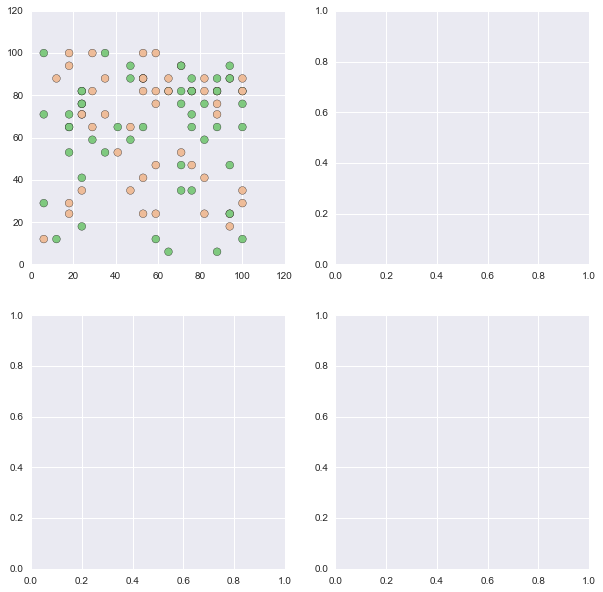

In [107]:
# Number of clusters is in num_clusters, set at the top.

# Do it again sampling questions from clusters formed
# by the 'average' algo:

(centroids, distortion) = initial[num_clusters - 1]

# Get as many colors as we have clusters:

number_of_colors = num_clusters
cm_subsection = np.linspace(0, 1, number_of_colors) 
accent_cmap = plt.cm.get_cmap('Accent')
colors = [ accent_cmap(x) for x in cm_subsection ]


# Assign each observation to one cluster:
(centroid_assignments, distortions) = cluster.vq.vq(qs_sliders, centroids)

# Get arrays of questions from the Ward clusters.
# But we only want the slider questions among those
# We'll then plot pairs of response vectors to random question pairs
# below:
green_ward_questions = ward_clusters[ward_clusters.Color == 'green'].index.intersection(qs_sliders.index)
red_ward_questions = ward_clusters[ward_clusters.Color == 'red'].index.intersection(qs_sliders.index)
cyan_ward_questions = ward_clusters[ward_clusters.Color == 'cyan'].index.intersection(qs_sliders.index)
blue_ward_questions = ward_clusters[ward_clusters.Color == 'blue'].index.intersection(qs_sliders.index)
magenta_ward_questions = ward_clusters[ward_clusters.Color == 'magenta'].index.intersection(qs_sliders.index)

#green_questions.sample().Question
#print(some_respondents[green_questions.sample().Question])
#green_questions

# Number of plots with different questions on x/y axes:
num_plots = 4
plot_cols = 2
plot_rows = int(np.ceil(num_plots / plot_cols))

# The axes_arr will have same shape as
# arrangement of plots: E.g. 3x2:
(fig, axes_arr) = plt.subplots(plot_rows,plot_cols)
axes = axes_arr.flatten()
fig.set_size_inches(10,10)

# Pick two clusters from which questions will be drawn:
questions_cluster_1 = green_ward_questions
questions_cluster_2 = green_ward_questions

for i in range(num_plots):
    cluster1_question = np.random.choice(questions_cluster_1)
    cluster2_question   = np.random.choice(questions_cluster_2)
    
    # Get responses to the two sample questions by all respondents:
    cluster1_responses      = qs_sliders.loc[cluster1_question]
    cluster2_responses      = qs_sliders.loc[cluster2_question]
    
    # Discard all respondents that did not answer *either*
    # question:    
    cluster1_non_responders = cluster1_responses.loc[cluster1_responses == 0]
    cluster2_non_responders = cluster2_responses.loc[cluster2_responses == 0]

    non_responders_either_q = cluster1_non_responders.index.union(cluster2_non_responders.index)

    # The remaining responses:
    good_cluster1_responses = cluster1_responses.drop(non_responders_either_q)
    good_cluster2_responses = cluster2_responses.drop(non_responders_either_q)

    the_plot = axes[i]
    the_plot.scatter(good_cluster1_responses, 
                     good_cluster2_responses,
                     #c=centroid_assignments, # color by centroid
                     c=colors[0:2],
                     cmap=accent_cmap,
                     s=60
                    ) # dot size
    the_plot.set_xlabel(green_question)
    the_plot.set_ylabel(red_question)
    
plt.tight_layout()
plt.show()


<hr>

In [ ]:
ward_clusters[ward_clusters.Color == 'green']
green_questions = ward_clusters[ward_clusters.Color == 'green']
red_questions = ward_clusters[ward_clusters.Color == 'red']
cyan_questions = ward_clusters[ward_clusters.Color == 'cyan']
blue_questions = ward_clusters[ward_clusters.Color == 'blue']

In [ ]:
ward_questions = ward_clusters['Question'].iloc[:31]
len(ward_questions)
#plt.plot(data[ward_questions])
some_respondents = good_obs.copy().ix[ward_questions].reset_index().rename(columns={'index' : 'Question'})
some_respondents = some_respondents.rename(columns={'question' : 'Question'})
thin_ward_clusters = ward_clusters[['Question', 'Color']].set_index('Question')
thin_some_respondents = some_respondents.set_index('Question')
thin_some_respondents = thin_some_respondents.join(thin_ward_clusters, how='inner')
#thin_some_respondents
#thin_ward_clusters


In [ ]:
import os
thin_some_respondents.reset_index().to_csv(os.path.join(os.getenv('HOME'), 'tmp/some_respondents.csv'))
thin_some_respondents


In [ ]:
green_ward_questions = ward_clusters[ward_clusters.Color == 'green']
red_ward_questions = ward_clusters[ward_clusters.Color == 'red']
cyan_ward_questions = ward_clusters[ward_clusters.Color == 'cyan']
blue_ward_questions = ward_clusters[ward_clusters.Color == 'blue']
magenta_ward_questions = ward_clusters[ward_clusters.Color == 'magenta']

#*****ward_clusters = ward_clusters.set_index('Question')
green_ward_questions = ward_clusters[ward_clusters.Color == 'green'].index.intersection(qs_sliders.index)

green_ward_questions
#len(ward_clusters[ward_clusters.Color == 'green'])

green_ward_questions = ward_clusters[ward_clusters.Color == 'green'].index.intersection(qs_sliders.index))
red_ward_questions = ward_clusters[ward_clusters.Color == 'red'].index.intersection(qs_sliders.index))
cyan_ward_questions = ward_clusters[ward_clusters.Color == 'cyan'].index.intersection(qs_sliders.index))
blue_ward_questions = ward_clusters[ward_clusters.Color == 'blue'].index.intersection(qs_sliders.index))
magenta_ward_questions = ward_clusters[ward_clusters.Color == 'magenta'].index.intersection(qs_sliders.index))



In [ ]:
green_ward_questions

In [ ]:
np.random.choice(green_ward_questions)

In [304]:
persExp_teamNotVal = qs_sliders.loc['PersonalExperience|TeamNotValuesMyWork']
persExp_teamNotVal_GT0 = persExp_teamNotVal[persExp_teamNotVal > 0]

persExp_evalNeg = qs_sliders.loc['PersonalExperience|EvaledNegativelyForShortcomings']
persExp_evalNeg_GT0 = persExp_evalNeg[persExp_evalNeg > 0]

In [316]:
print('len(persExp_teamNotVal_GT0) : %s' % len(persExp_teamNotVal_GT0))
print('len(persExp_evalNeg_GT0): %s' % len(persExp_evalNeg_GT0))
persExp_teamNotVal_GT0.corr(persExp_evalNeg_GT0)

len(persExp_teamNotVal_GT0) : 99
len(persExp_evalNeg_GT0): 97


0.68456838976823631

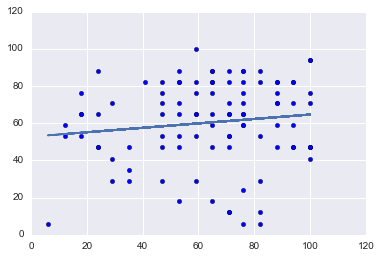

In [319]:
x = persExp_teamNotVal_GT0.sample(97)
y = persExp_evalNeg_GT0
plt.scatter(x,y)
(m,b) = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, '-')